In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

from pandarallel import pandarallel
from tqdm.auto import tqdm
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

data_dir = Path("../data/")
embeddings_dir = data_dir / "track_embeddings"
N_TAGS = 256
TEST_SIZE = 0.1
SEED = 0
N_THREADS = 4
N_FOLDS = 5
TIMEOUT = 300

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
# LightAutoML presets, task and report generation
# pip install -U lightautoml

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco


In [2]:
df_train = pd.read_csv(data_dir / 'train.csv')
df_test = pd.read_csv(data_dir / 'test.csv')

In [10]:
def process_tags(tags): 
    tags = list(map(int, tags.split(",")))
    return tags


tags = df_train["tags"].parallel_apply(process_tags)

In [6]:
tags.map(len).values.max(), tags.map(len).values.min(), tags.map(len).values.mean()

(33, 1, 3.941839089451246)

In [3]:
def get_embedding(track_id):
    embeddings = np.load(embeddings_dir / f"{track_id}.npy")
    # embedding = np.mean(embeddings, axis=0)
    return embeddings #.tolist()

df_train["embedding"] = df_train.track.parallel_apply(get_embedding)
df_test["embedding"] = df_test.track.parallel_apply(get_embedding)
df_train["emb_shape"] = [emb.shape[0] for emb in df_train["embedding"].values]
df_test["emb_shape"] = [emb.shape[0] for emb in df_test["embedding"].values]

In [4]:
df_train["emb_shape"].describe()

count    51134.000000
mean        58.099934
std         26.633522
min         10.000000
25%         43.000000
50%         53.000000
75%         68.000000
max        404.000000
Name: emb_shape, dtype: float64

In [5]:
df_test["emb_shape"].describe()

count    25580.000000
mean        57.925215
std         25.727005
min         10.000000
25%         43.000000
50%         53.000000
75%         68.000000
max        386.000000
Name: emb_shape, dtype: float64

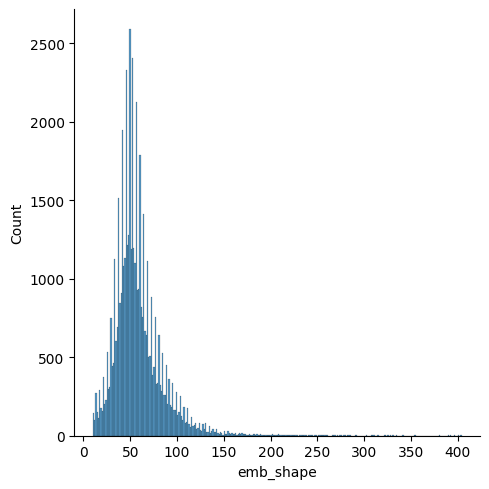

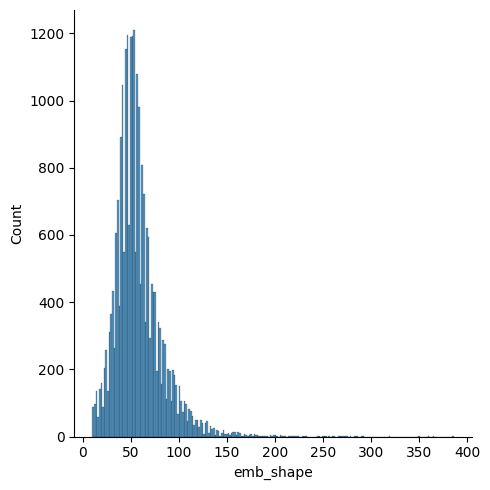

In [6]:
import seaborn as sns
sns.displot(df_train["emb_shape"])
sns.displot(df_test["emb_shape"])

In [7]:
df_train[[f"f{i}" for i in range(768)]] = pd.DataFrame(df_train.embedding.tolist(), index=df_train.index)

/tmp/ipykernel_1777280/2228830240.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[[f"f{i}" for i in range(768)]] = pd.DataFrame(df_train.embedding.tolist(), index=df_train.index)
/tmp/ipykernel_1777280/2228830240.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[[f"f{i}" for i in range(768)]] = pd.DataFrame(df_train.embedding.tolist(), index=df_train.index)
/tmp/ipykernel_1777280/2228830240.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

In [8]:
def process_tags(tags): 
    tags = list(map(int, tags.split(",")))
    one_hot_tags = np.zeros(N_TAGS, dtype=np.uint8)
    one_hot_tags[tags] = 1
    return one_hot_tags.tolist()


df_train[[f"tag{i}" for i in range(N_TAGS)]] = pd.DataFrame(df_train["tags"].parallel_apply(process_tags).tolist(), index=df_train.index)

/tmp/ipykernel_1777280/3814522717.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[[f"tag{i}" for i in range(N_TAGS)]] = pd.DataFrame(df_train["tags"].parallel_apply(process_tags).tolist(), index=df_train.index)
/tmp/ipykernel_1777280/3814522717.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[[f"tag{i}" for i in range(N_TAGS)]] = pd.DataFrame(df_train["tags"].parallel_apply(process_tags).tolist(), index=df_train.index)
/tmp/ipykernel_1777280/3814522717.py:8: PerformanceWarning: DataFrame is highly fragme

In [10]:
df_train.head()

,track,tags,embedding,f0,f1,f2,f3,f4,f5,f6,...,tag246,tag247,tag248,tag249,tag250,tag251,tag252,tag253,tag254,tag255
0,49734,"5,6,9,26,32,55,96","[0.007893690839409828, 0.15074634552001953, 0....",0.007894,0.150746,0.268556,-0.123826,0.415290,-0.180336,0.229614,...,0,0,0,0,0,0,0,0,0,0
1,67845,"6,9,28,39,145,155","[0.12421309947967529, 0.18337762355804443, 0.2...",0.124213,0.183378,0.286596,-0.100277,0.409706,-0.236483,0.209988,...,0,0,0,0,0,0,0,0,0,0
2,25302,"0,6,28,40,116,168","[0.17797555029392242, 0.07382377982139587, 0.2...",0.177976,0.073824,0.228476,-0.062496,0.303353,-0.166569,0.223461,...,0,0,0,0,0,0,0,0,0,0
3,57796,"28,186","[0.17672187089920044, 0.16318991780281067, 0.2...",0.176722,0.163190,0.204621,-0.174427,0.484905,-0.092025,0.216220,...,0,0,0,0,0,0,0,0,0,0
4,13676,"6,23,177","[0.04586225003004074, 0.1584373563528061, 0.16...",0.045862,0.158437,0.168475,-0.011589,0.444241,-0.297196,0.082658,...,0,0,0,0,0,0,0,0,0,0


# Light Auto ML

In [26]:
task = Task(
    name='multilabel',
    metric=lambda y_true, y_pred: average_precision_score(y_true, y_pred)
)
automl = TabularAutoML(
    task, 
    memory_limit=32,
    timeout=60 * 2,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': SEED},
    general_params = {'use_algos': 'auto'},
)

[14:52:25] CatBoost uses as obj. MultiCrossEntropy.


In [35]:
train_data, val_data = train_test_split(
    df_train,
    test_size=0.2,
    random_state=SEED
)

In [ ]:
oof_pred = automl.fit_predict(
    train_data,
    roles={'target': [f"tag{i}" for i in range(N_TAGS)], 'drop': ["tags", "embedding", "track"]},
    verbose=4
)

In [ ]:
# test_pred = automl.predict(df_test)